In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gc import collect as collect_garbage
from psutil import virtual_memory
from os import scandir

In [2]:
%matplotlib widget

In [3]:
# Imports the data and gives it the index necessary for this file

def import_data(infant_number):
    folder = "01-outputs/01-rr-intervals/"
    files = sorted( [file.name for file in scandir("01-outputs/01-rr-intervals/") if str(infant_number) in file.name] )
    print(files)

    df = pd.read_csv(folder + files.pop(0))
    for file in files:
        df = df.append(pd.read_csv(folder + file))
        collect_garbage()
    df.reset_index(inplace=True, drop=True)
    
    observation_time = df["time"][len(df["time"])-1] - df["time"][0]
    center_time = observation_time/2 + df["time"][0]

    df["time"] = df["time"] - center_time
    df["datetime"] = pd.to_datetime(df["time"], unit="s")
    df.set_index(df["datetime"], inplace=True)
    df.drop("datetime", inplace=True, axis=1)

    return df

# Returns a time series of the mean RR interval over a sliding window 
def mean_rr(df, offset):
    return(df["interval"].rolling(offset).mean())

# Returns a time series of the SDRR over a sliding window 
def sdrr(df, offset):
    return(df["interval"].rolling(offset).std())

# Returns a time series of the RMSSD over a sliding window
def rmssd(df, offset):
    temp = pd.DataFrame( df["interval"].diff(), index=df.index)
    temp.columns = ["SD"]

    temp["SSD"] = temp["SD"]**2
    temp["MSSD"] = temp["SSD"].rolling(offset).mean()
    temp["RMSSD"] = np.sqrt(temp["MSSD"])

    out = pd.DataFrame.copy(temp["RMSSD"], deep=True)
    out.columns = ["RMSSD"]

    del temp
    collect_garbage()

    return out

# Returns a time series of the pNNk over a sliding window, for your choice of k
def pNN(k, df, offset):
    temp = pd.DataFrame( np.abs(df["interval"].diff()), index=df.index )
    

    # k is typically given in ms, but the abs SD are in seconds
    temp["over k"] = (temp["interval"] > k/1000)

    temp["denominator"] = temp["over k"].rolling(offset).count()
    temp["numerator"] = temp["over k"].rolling(offset).sum()
    temp["pNN"+str(k)] = temp["numerator"]/temp["denominator"]

    out = pd.DataFrame.copy(temp["pNN"+str(k)], deep=True)
    out.columns = ["pNN"+str(k)]

    del temp
    collect_garbage()

    return out

def calc_hrv(df, offset):
    out = pd.DataFrame(df["time"])
    out["Mean RR"] = mean_rr(df, offset)
    out["SDRR"] = sdrr(df, offset)
    out["RMSSD"] = rmssd(df, offset)
    out["pNN20"] = pNN(20, df, offset)
    out["pNN50"] = pNN(50, df, offset)
    return out

def stack_figures(dfs, offset, time_unit="D", indices=None):
    time_unit_dict = {
        "s": 1,
        "min": 60,
        "H": 3600,
        "D": 86400,
        "W": 604800
    }

    print("Memory before drawing figures: " + str(virtual_memory()[2])+"%")

    if indices == None:
        indices = [i for i in range(len(dfs))]

    temp = [dfs[i] for i in indices]

    fig1 = plt.figure()
    for df in temp:
        times = df["time"] / time_unit_dict[time_unit]
        plt.plot(times, df["Mean RR"], linewidth=0.75)
    
    plt.xlabel("Time (" + time_unit + ")")
    plt.ylabel("Mean RR (sec)")
    plt.legend(["Infant " + str(i + 1) for i in indices], loc="upper left")
    plt.title("Mean RR Interval over Time, Offset="+str(offset))
    plt.axvline(color="red", linewidth="1")
    plt.show()

    fig2 = plt.figure()
    for df in temp:
        times = df["time"] / time_unit_dict[time_unit]
        plt.plot(times, df["SDRR"], linewidth=0.75)
    
    plt.xlabel("Time (" + time_unit + ")")
    plt.ylabel("SDRR (sec)")
    plt.legend(["Infant " + str(i + 1) for i in indices], loc="upper left")
    plt.title("SDRR over Time, Offset="+str(offset))
    plt.axvline(color="red", linewidth="1")
    plt.show()

    fig3 = plt.figure()
    for df in temp:
        times = df["time"] / time_unit_dict[time_unit]
        plt.plot(times, df["RMSSD"], linewidth=0.75)
    
    plt.xlabel("Time (" + time_unit + ")")
    plt.ylabel("RMSSD (sec)")
    plt.legend(["Infant " + str(i + 1) for i in indices], loc="upper left")
    plt.title("RMSSD over Time, Offset="+str(offset))
    plt.axvline(color="red", linewidth="1")
    plt.show()

    fig4 = plt.figure()
    for df in temp:
        times = df["time"] / time_unit_dict[time_unit]
        plt.plot(times, df["pNN20"], linewidth=0.75)
    
    plt.xlabel("Time (" + time_unit + ")")
    plt.ylabel("pNN20")
    plt.legend(["Infant " + str(i + 1) for i in indices], loc="upper left")
    plt.title("pNN20 over Time, Offset="+str(offset))
    plt.axvline(color="red", linewidth="1")
    plt.show()

    fig4 = plt.figure()
    for df in temp:
        times = df["time"] / time_unit_dict[time_unit]
        plt.plot(times, df["pNN50"], linewidth=0.75)
    
    plt.xlabel("Time (" + time_unit + ")")
    plt.ylabel("pNN50")
    plt.legend(["Infant " + str(i + 1) for i in indices], loc="upper left")
    plt.title("pNN50 over Time, Offset="+str(offset))
    plt.axvline(color="red", linewidth="1")
    plt.show()

def one_figure(dfs, offset, stat, time_unit="D", indices=None):
    time_unit_dict = {
        "s": 1,
        "min": 60,
        "H": 3600,
        "D": 86400,
        "W": 604800
    }

    print("Memory before drawing figures: " + str(virtual_memory()[2])+"%")

    if indices == None:
        indices = [i for i in range(len(dfs))]

    temp = [dfs[i] for i in indices]

    fig1 = plt.figure()
    for df in temp:
        times = df[stat] / time_unit_dict[time_unit]
        plt.plot(times, df[stat], linewidth=0.75)
    
    plt.xlabel("Time (s)")
    plt.ylabel("Mean RR (sec)")
    plt.legend(["Infant " + str(i + 1) for i in indices], loc="upper left")
    plt.title(stat + "Interval over Time, Offset="+str(offset))
    plt.axvline(color="red", linewidth="1")
    plt.show()

In [4]:
dfs = [ import_data(i) for i in range(1,8)]
offset = "12H"

hrvs = [calc_hrv(df, offset=offset) for df in dfs]

del dfs
collect_garbage()
print(virtual_memory())

['rr_intervals_1a.csv', 'rr_intervals_1b.csv', 'rr_intervals_1c.csv', 'rr_intervals_1d.csv', 'rr_intervals_1e.csv']
['rr_intervals_2a.csv', 'rr_intervals_2b.csv', 'rr_intervals_2c.csv', 'rr_intervals_2d.csv', 'rr_intervals_2e.csv']
['rr_intervals_3a.csv', 'rr_intervals_3b.csv', 'rr_intervals_3c.csv', 'rr_intervals_3d.csv', 'rr_intervals_3e.csv']
['rr_intervals_4a.csv', 'rr_intervals_4b.csv', 'rr_intervals_4c.csv', 'rr_intervals_4d.csv', 'rr_intervals_4e.csv']
['rr_intervals_5a.csv', 'rr_intervals_5b.csv', 'rr_intervals_5c.csv', 'rr_intervals_5d.csv', 'rr_intervals_5e.csv']
['rr_intervals_6a.csv', 'rr_intervals_6b.csv', 'rr_intervals_6c.csv', 'rr_intervals_6d.csv', 'rr_intervals_6e.csv']
['rr_intervals_7a.csv', 'rr_intervals_7b.csv', 'rr_intervals_7c.csv', 'rr_intervals_7d.csv', 'rr_intervals_7e.csv']
svmem(total=12655771648, available=7522926592, percent=40.6, used=5132845056, free=7522926592)


Memory before drawing figures: 40.8%


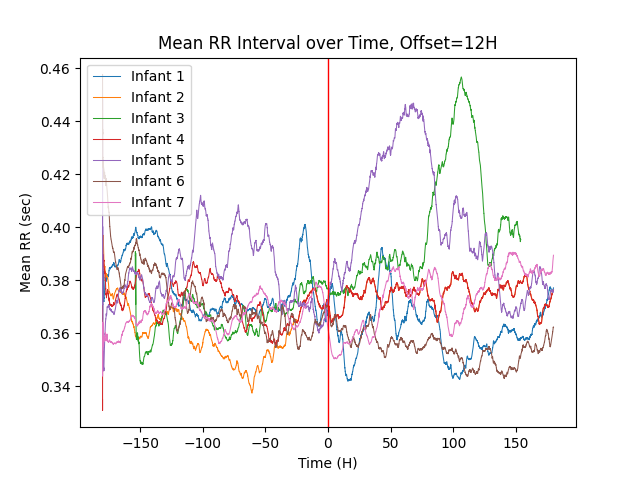

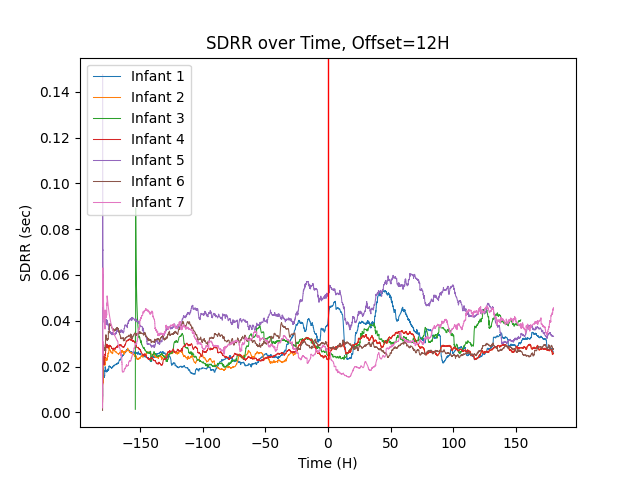

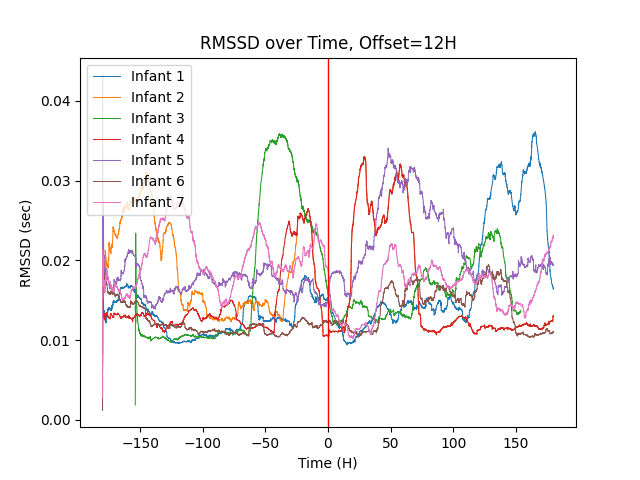

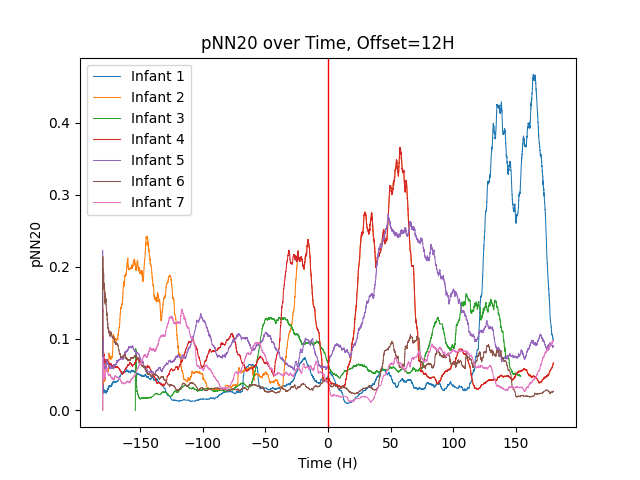

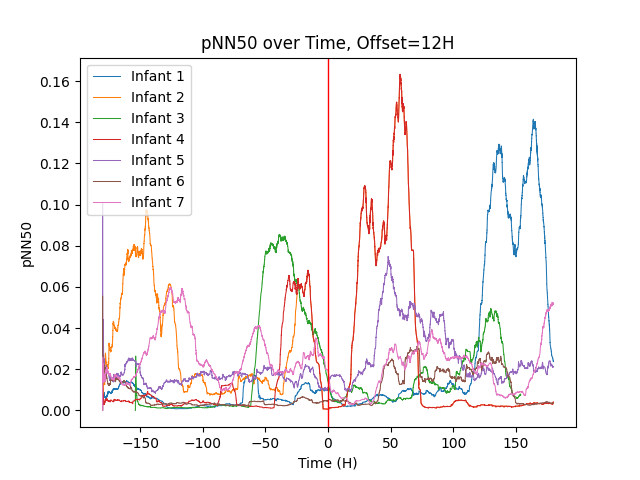

In [5]:
stack_figures(hrvs, offset, indices=None, time_unit="H")